In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_comparison(td3_paths=None, expd3_paths=None, smooth_length=10):
    """
    Plots and compares the evaluation reward and success rate of TD3 and ExpD3 algorithms.
    If only one algorithm is provided, it plots only that.

    Parameters:
        td3_paths (list or None): List of NPZ file paths for TD3.
        expd3_paths (list or None): List of NPZ file paths for ExpD3.
        smooth_length (int): Window size for smoothing the data.
    """

    def load_and_interpolate(file_paths, time_common):
        """Loads and interpolates reward and success data onto a common time axis."""
        if not file_paths:
            return None, None  # Return None if no paths provided

        time_lists, reward_lists, success_lists = [], [], []

        for file_path in file_paths:
            data = np.load(file_path)
            time_lists.append(data["Total_Time_List"] / 3600)  # Convert seconds to hours
            reward_lists.append(data["Evaluation_Reward_List"])
            success_lists.append(data["Evaluation_Success_List"])

        # Interpolate all data onto the common time axis
        reward_interp, success_interp = [], []
        for i in range(len(file_paths)):
            reward_interp.append(interp1d(time_lists[i], reward_lists[i], kind='linear', fill_value="extrapolate")(time_common))
            success_interp.append(interp1d(time_lists[i], success_lists[i], kind='linear', fill_value="extrapolate")(time_common))

        return np.array(reward_interp), np.array(success_interp)

    def compute_stats(data):
        """Computes mean and confidence intervals (std for reward, 25-75 percentile for success)."""
        if data is None:
            return None, None, None, None  # Return None if no data
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        p25 = np.percentile(data, 25, axis=0)
        p75 = np.percentile(data, 75, axis=0)
        return mean, std, p25, p75

    def smooth(data, length):
        """Applies a moving average smoothing."""
        if data is None:
            return None
        pad = np.repeat(data[0], length - 1)  # Padding with the first value
        pad_data = np.concatenate((pad, data))
        return np.array([np.mean(pad_data[i:i + length]) for i in range(len(data))])

    # Determine the common time axis
    all_paths = (td3_paths or []) + (expd3_paths or [])  # Combine non-empty lists
    if not all_paths:
        print("No valid file paths provided.")
        return

    max_time = max(np.load(f)["Total_Time_List"][-1] for f in all_paths) / 3600
    num_points = max(len(np.load(f)["Total_Time_List"]) for f in all_paths)
    time_common = np.linspace(0, max_time, num_points)

    # Load, interpolate, and compute statistics
    reward_td3, success_td3 = load_and_interpolate(td3_paths, time_common)
    reward_expd3, success_expd3 = load_and_interpolate(expd3_paths, time_common)

    reward_td3_mean, reward_td3_std, _, _ = compute_stats(reward_td3)
    reward_expd3_mean, reward_expd3_std, _, _ = compute_stats(reward_expd3)
    success_td3_mean, _, success_td3_25, success_td3_75 = compute_stats(success_td3)
    success_expd3_mean, _, success_expd3_25, success_expd3_75 = compute_stats(success_expd3)

    # Apply smoothing
    reward_td3_mean, reward_td3_std = smooth(reward_td3_mean, smooth_length), smooth(reward_td3_std, smooth_length)
    reward_expd3_mean, reward_expd3_std = smooth(reward_expd3_mean, smooth_length), smooth(reward_expd3_std, smooth_length)
    success_td3_mean, success_td3_25, success_td3_75 = smooth(success_td3_mean, smooth_length), smooth(success_td3_25, smooth_length), smooth(success_td3_75, smooth_length)
    success_expd3_mean, success_expd3_25, success_expd3_75 = smooth(success_expd3_mean, smooth_length), smooth(success_expd3_25, smooth_length), smooth(success_expd3_75, smooth_length)

    # Plot both figures side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Evaluation Reward
    if reward_td3_mean is not None:
        axes[0].plot(time_common, reward_td3_mean, label="TD3 Mean Reward", linestyle="--", color="blue", linewidth=2)
        axes[0].fill_between(time_common, reward_td3_mean + reward_td3_std, reward_td3_mean - reward_td3_std, alpha=0.2, color="blue")

    if reward_expd3_mean is not None:
        axes[0].plot(time_common, reward_expd3_mean, label="ExpD3 Mean Reward", linestyle="--", color="red", linewidth=2)
        axes[0].fill_between(time_common, reward_expd3_mean + reward_expd3_std, reward_expd3_mean - reward_expd3_std, alpha=0.2, color="red")

    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Smoothed Evaluation Reward")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Evaluation Success
    if success_td3_mean is not None:
        axes[1].plot(time_common, success_td3_mean, label="TD3 Mean Success", linestyle="--", color="green", linewidth=2)
        axes[1].fill_between(time_common, success_td3_25, success_td3_75, alpha=0.2, color="green")

    if success_expd3_mean is not None:
        axes[1].plot(time_common, success_expd3_mean, label="ExpD3 Mean Success", linestyle="--", color="orange", linewidth=2)
        axes[1].fill_between(time_common, success_expd3_25, success_expd3_75, alpha=0.2, color="orange")

    axes[1].set_xlabel("Time (hours)")
    axes[1].set_ylabel("Success Rate")
    axes[1].set_title("Smoothed Evaluation Success")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

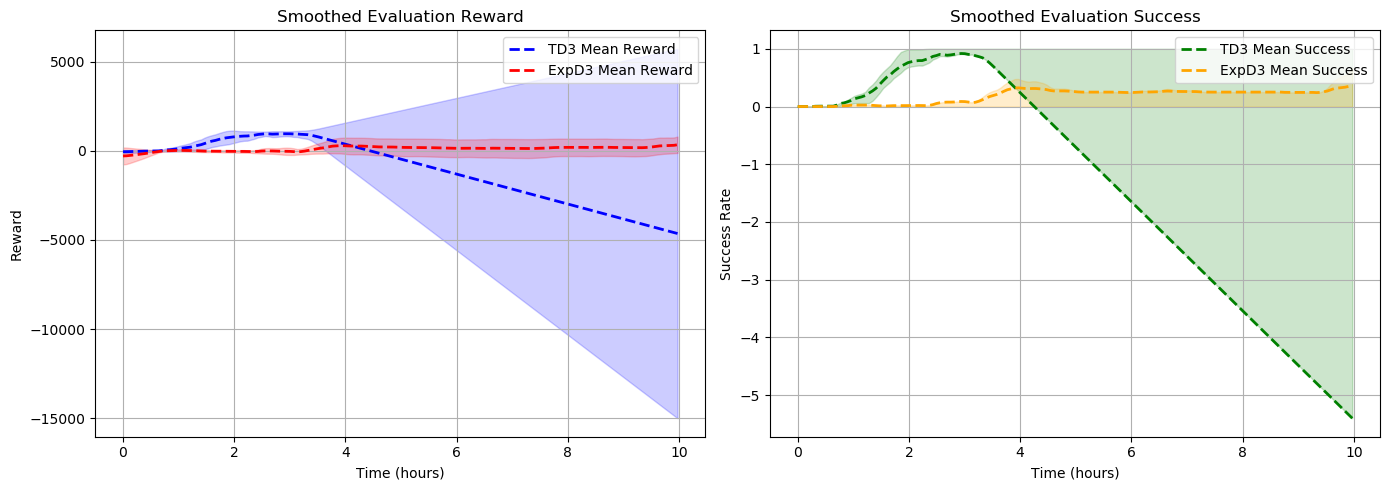

In [15]:
# Example Usage:
td3_files = [
    "./results/eval_TD3_64_128_3.npz",
    "./results/eval_TD3_64_128_2.npz",
    "./results/eval_TD3_64_128_1.npz",
    "./results/eval_TD3_64_128_0.npz",
]

expd3_files = [
    "./results/eval_ExpD3_64_128_3.npz",
    "./results/eval_ExpD3_64_128_2.npz",
    "./results/eval_ExpD3_64_128_1.npz",
    "./results/eval_ExpD3_64_128_0.npz",
]

plot_comparison(td3_files, expd3_files, smooth_length=10)
